In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
from ipywidgets import interact, FloatSlider
import numpy as np
import SimpleITK as sitk

# Download data to work on
%run update_path_to_download_script
from downloaddata import fetch_data as fdata
from myshow import myshow, myshow3d
# import itk
import gui
import os

In [2]:
import os
os.getcwd()

'C:\\Users\\Chia\\AppData\\Roaming\\SPB_16.6'

In [3]:
#image upload and rescaling

DIR="C:\\snap\\healthy"
img = sitk.ReadImage("C://Users//Chia//Desktop//Second Year//HospitalProject//CTA_Head.nrrd")

img_255 = sitk.Cast(sitk.RescaleIntensity(img), sitk.sitkInt32)

myshow(img_255)

interactive(children=(IntSlider(value=75, description='z', max=150), Output()), _dom_classes=('widget-interact…

In [4]:
# Otsu thresholding filter -> binary image
FOV_mask = sitk.OtsuThreshold(img,0,1)
FOV_image = sitk.Mask(img,FOV_mask)
OTSU_mask = sitk.OtsuThreshold(FOV_image)
OTSU_image = sitk.Mask(img,OTSU_mask)
otsu_255 = sitk.Cast(sitk.RescaleIntensity(OTSU_image), sitk.sitkInt32)
myshow(OTSU_image)

# sitk.WriteImage(otsu_255, os.path.join(DIR, 'otzu.mhd'))
# myshow(otsu_255)

interactive(children=(IntSlider(value=75, description='z', max=150), Output()), _dom_classes=('widget-interact…

In [5]:
#segmentation
seed = (174,114,76)
seg_reg = sitk.Image(otsu_255.GetSize(), sitk.sitkInt32)
seg_reg.CopyInformation(otsu_255)
seg_reg[seed] = 1
seg_reg = sitk.BinaryDilate(seg_reg, 3)
myshow(sitk.LabelOverlay(otsu_255, seg_reg), "Initial Seed")

interactive(children=(IntSlider(value=75, description='z', max=150), Output()), _dom_classes=('widget-interact…

In [6]:
seg_reg = sitk.ConnectedThreshold(otsu_255, seedList=[seed], lower=0, upper=150)
myshow(sitk.LabelOverlay(otsu_255, seg_reg), "Connected Threshold")
print(seg_reg.GetSize())
# sitk.WriteImage(seg_reg, os.path.join(DIR, 'segm.mhd'))

interactive(children=(IntSlider(value=75, description='z', max=150), Output()), _dom_classes=('widget-interact…

(340, 347, 151)


In [7]:
# Cropping segmentation
#best way to crop using ROI filter
filt=sitk.RegionOfInterestImageFilter()

filt.SetIndex([127,81,23])#,[84,208,14],[166,208,14],[84,121,36], [166,121,36],[84,208,36],[166,208,36])
filt.SetSize([221-127,156-81, 101-23])
cr1=filt.Execute(seg_reg)

# sitk.WriteImage(cr1, os.path.join(DIR, 'segmentation1.mhd'))

myshow(cr1)

interactive(children=(IntSlider(value=38, description='z', max=77), Output()), _dom_classes=('widget-interact'…

In [8]:
#transformation of the image in vector
nda = sitk.GetArrayFromImage(cr1)

v = seg_reg.GetSpacing()
V_voxel = v[0]*v[1]*v[2]

s=nda.shape

V_slice3=[]
for z in range(s[0]):
    V_slice = 0
    for y in range(s[1]):
        for x in range(s[2]):
            if nda[z][y][x] == 1:
                V_slice = V_slice+1
            
    V_slice3.append(V_slice*V_voxel)


In [9]:
s


(78, 75, 94)

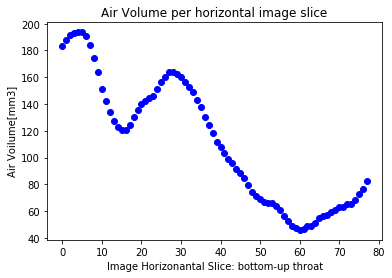

In [10]:
plt.plot(V_slice3, 'bo')

plt.title('Air Volume per horizontal image slice')
plt.ylabel('Air Voilume[mm3]')
plt.xlabel('Image Horizonantal Slice: bottom-up throat')
plt.show()

In [15]:
#center line with skimage
from skimage import morphology

nda = sitk.GetArrayFromImage(cr1)
# # # print(nda)
axis_arr=skimage.morphology.skeletonize_3d(nda)
axis = sitk.GetImageFromArray(axis_arr)
#sitk.WriteImage(axis, os.path.join(DIR, 'img_sciskeleton3D.mhd'))

myshow(axis, "middle line")

interactive(children=(IntSlider(value=38, description='z', max=77), Output()), _dom_classes=('widget-interact'…

In [12]:
import numpy as np
print(np.__version__)

1.15.4


In [16]:

from scipy.spatial import distance

size=cr1.GetSize()
s=size[2]
eu_s=[]
for z in range(0, size[2]):
    slicex=nda[:][:][z]
    sliceindex=slicex.nonzero()

    skelx=axis_arr[:][:][z]
    skelindex=skelx.nonzero()
    eu_p=[]
    if skelindex[0][:].size == 1:
        for p in range(0,sliceindex[1][:].size):
            a=(sliceindex[0][p], sliceindex[1][p])
            b=(skelindex[0], skelindex[1])
            euclide=distance.euclidean(a, b)
            eu_p.append(euclide)
        eu=np.hstack(eu_p)
        e=max(eu)
        
    else: e=0
    eu_s.append(e)    
cross_sec=np.hstack(eu_s)
        

In [17]:
print(cross_sec)

[ 0.          0.          0.          0.         36.05551275  0.
  0.          0.          0.          0.          0.          0.
  0.          0.         28.16025568 28.16025568 29.15475947 28.28427125
 28.28427125  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 29.61418579 30.2654919  30.2654919  29.15475947 28.7923601  28.7923601
 28.7923601  28.23118843 27.31300057 26.83281573 26.41968963 26.41968963
 26.41968963 26.41968963 24.18677324 23.32380758 21.63330765 20.80865205
 17.02938637 15.         15.65247584 17.08800749 17.08800749 18.02775638
 18.43908891 17.2626765  14.14213562 12.52996409 12.36931688 12.64911064
 12.64911064 13.         14.31782106 14.31782106 13.92838828 14.56021978
 14.56021978 15.23154621 14.86606875 14.86606875 14.31782106 14.14213562
 14.76482306  0.          0.         16.4924225   0.          0.        ]


In [18]:
x=range(0, 78)
x=np.array(x)
print(x)
coss=np.array(cross_sec)
print(coss)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
[ 0.          0.          0.          0.         36.05551275  0.
  0.          0.          0.          0.          0.          0.
  0.          0.         28.16025568 28.16025568 29.15475947 28.28427125
 28.28427125  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 29.61418579 30.2654919  30.2654919  29.15475947 28.7923601  28.7923601
 28.7923601  28.23118843 27.31300057 26.83281573 26.41968963 26.41968963
 26.41968963 26.41968963 24.18677324 23.32380758 21.63330765 20.80865205
 17.02938637 15.         15.65247584 17.08800749 17.08800749 18.02775638
 18.43908891 17.2626765  14.14213562 12.52996409 12.36931688 12.64911064
 12.64911064 13.         14.31782106 14.31782106 13.92838828 14.

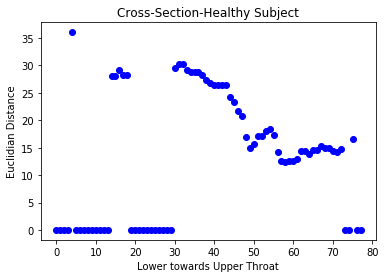

In [19]:
plt.plot(coss, 'bo')

plt.title('Cross-Section-Healthy Subject')
plt.ylabel('Euclidian Distance')
plt.xlabel('Lower towards Upper Throat')
plt.show()